<a href="https://colab.research.google.com/github/nikhilcms/EMNIST-alphabet-prediction-using-ANN-and-CNN/blob/master/inoplexus_sentiment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)
downloaded = drive.CreateFile({'id':'1IDo7IM4eyB3oynyI2scGMsNj30tI5oRI'})
downloaded.GetContentFile('training_data.csv') 

In [3]:
import numpy as np
import pandas as pd
from keras.models import Model
from keras.layers import Input, Dense, Embedding, SpatialDropout1D, Dropout, add, concatenate
from keras.layers import CuDNNLSTM, Bidirectional, GlobalMaxPooling1D, GlobalAveragePooling1D
from keras.preprocessing import text, sequence
from keras.callbacks import LearningRateScheduler
import time
import pickle
import re

Using TensorFlow backend.


In [0]:
#======================Import dataset========================#
train = pd.read_csv('training_data.csv')

In [5]:
train.head(10)

,unique_hash,text,drug,sentiment
0,2e180be4c9214c1f5ab51fd8cc32bc80c9f612e0,Autoimmune diseases tend to come in clusters. ...,gilenya,2
1,9eba8f80e7e20f3a2f48685530748fbfa95943e4,I can completely understand why you’d want to ...,gilenya,2
2,fe809672251f6bd0d986e00380f48d047c7e7b76,Interesting that it only targets S1P-1/5 recep...,fingolimod,2
3,bd22104dfa9ec80db4099523e03fae7a52735eb6,"Very interesting, grand merci. Now I wonder wh...",ocrevus,2
4,b227688381f9b25e5b65109dd00f7f895e838249,"Hi everybody, My latest MRI results for Brain ...",gilenya,1
5,a043780c757966243779bf3c0d11bf6eef721971,I can’t give you advice about Lemtrada because...,cladribine,2
6,be5a13376933a7f9bbf8e801c31691092f63260a,Reply posted for JessZidek. Hi Jess Sorry to r...,humira,0
7,08c3c0c702fc97d290204b37798ac62005da5626,Well as expected my Neurologist wants me to st...,gilenya,2
8,8fd3d7ad80791c9343e5cf8a83bd1adf6577d516,Why do you think that FIngolimod was such a mi...,fingolimod,1
9,793c5af7cc8332df17eb602247d886fbd1c80f89,Thank you so much…I’m learning a lot here at G...,tagrisso,2


In [0]:
#  1 is negative, 2 is neutral, 0 is positive

In [7]:
train['sentiment'].value_counts()

2    3825
1     837
0     617
Name: sentiment, dtype: int64

Text(0, 0.5, 'Number of reviews ')

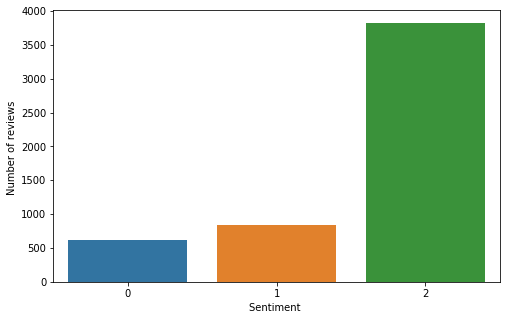

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
x = np.array(train['sentiment'].value_counts().index)
y = np.array(train['sentiment'].value_counts().values)
plt.figure(figsize=(8,5))
sns.barplot(x,y)
plt.xlabel('Sentiment ')
plt.ylabel('Number of reviews ')

In [9]:
print('Number of sentences in training set:',len(train['unique_hash'].unique()))
print('Average words per sentence in train:',train.groupby('unique_hash')['text'].count().mean())

Number of sentences in training set: 5279
Average words per sentence in train: 1.0


In [0]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
stopwords = set(STOPWORDS)

def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color='black',
        stopwords=stopwords,
        max_words=200,
        max_font_size=40, 
        scale=3,
        random_state=1 # chosen at random by flipping a coin; it was heads
).generate(str(data))

    fig = plt.figure(1, figsize=(15, 15))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)

    plt.imshow(wordcloud)
    plt.show()

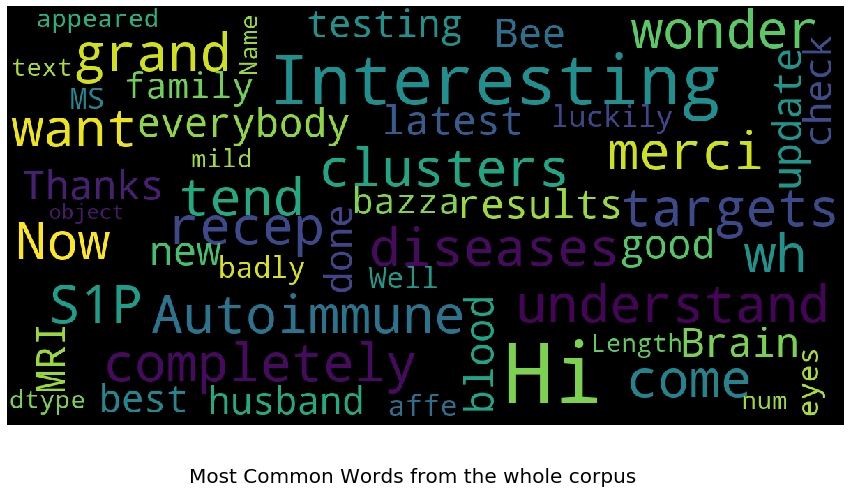

In [11]:
show_wordcloud(train['text'],'Most Common Words from the whole corpus')

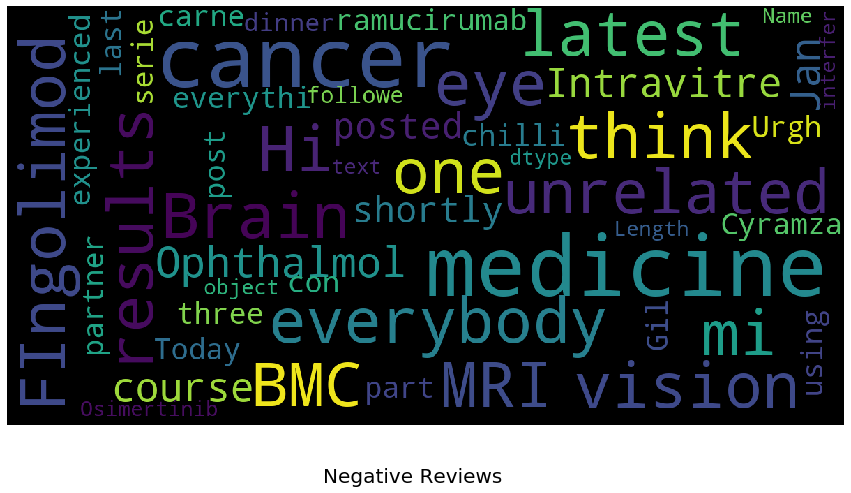

In [12]:
show_wordcloud(train[train['sentiment'] == 1]['text'],'Negative Reviews')

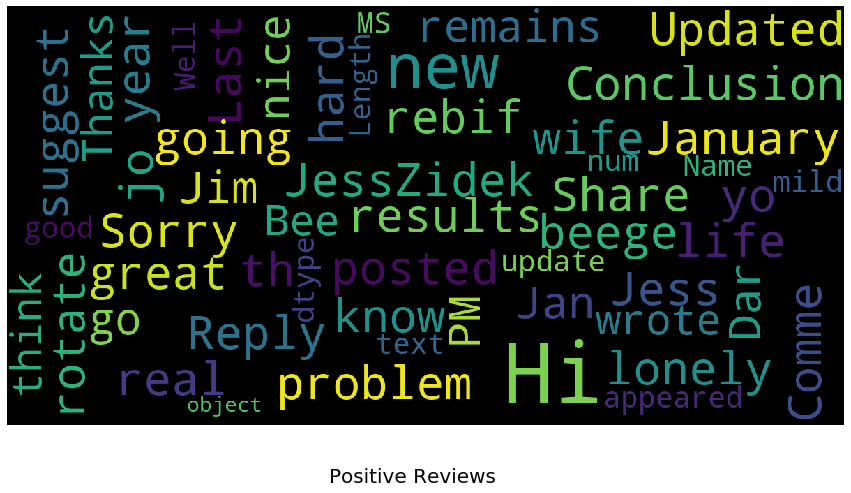

In [13]:
show_wordcloud(train[train['sentiment'] == 0]['text'],'Positive Reviews')

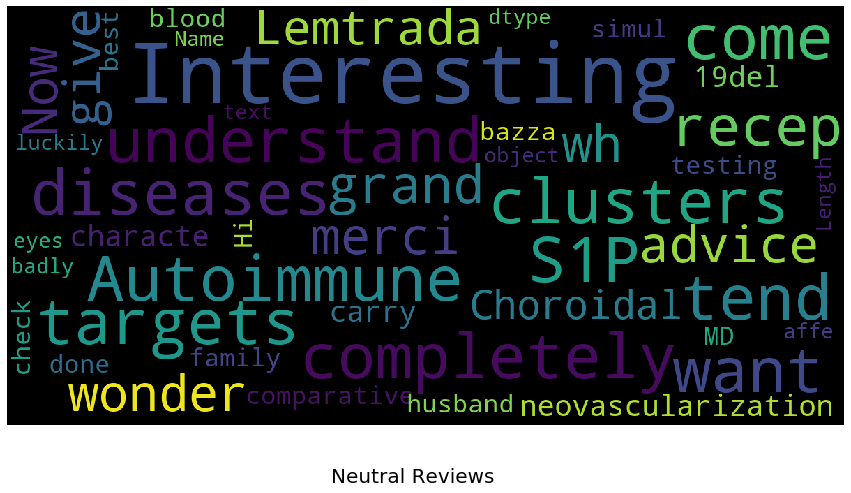

In [14]:
show_wordcloud(train[train['sentiment'] == 2]['text'],'Neutral Reviews')

In [0]:
df = train

In [16]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [0]:
import string
punctuation=string.punctuation
df['word_count']=df['text'].apply(lambda x: len(str(x).split(" ")))
df['char_count'] = df['text'].str.len()
def avg_word(sentence):
    words = sentence.split()
    return (sum(len(word) for word in words)/len(words))

df['avg_word'] = df['text'].apply(lambda x: avg_word(x))
from nltk.corpus import stopwords
stop = stopwords.words('english')

df['stopwords'] = df['text'].apply(lambda x: len([x for x in x.split() if x in stop]))
df['numerics'] = df['text'].apply(lambda x: len([x for x in x.split() if x.isdigit()]))
df['upper'] = df['text'].apply(lambda x: len([x for x in x.split() if x.isupper()]))
df['word_density'] = df['char_count'] / (df['word_count']+1)
df['punctuation_count'] = df['text'].apply(lambda x: len("".join(_ for _ in x if _ in punctuation)))

In [0]:
df['drug']=pd.factorize(df['drug'])[0]

In [19]:
df['drug'].sample(10)

2331    34
2966    40
4372     2
1778     0
3797     0
5178     3
1261     0
3550    52
2810     1
2258    10
Name: drug, dtype: int64

In [0]:
from keras.preprocessing.text import Tokenizer
from sklearn.feature_extraction.text import TfidfVectorizer
tokenizer = Tokenizer()

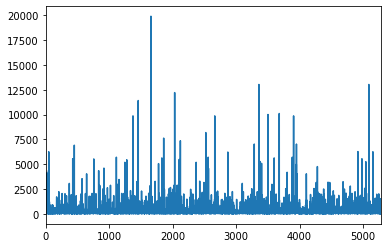

In [21]:
df.word_count.plot()

In [22]:
df.head()

,unique_hash,text,drug,sentiment,word_count,char_count,avg_word,stopwords,numerics,upper,word_density,punctuation_count
0,2e180be4c9214c1f5ab51fd8cc32bc80c9f612e0,Autoimmune diseases tend to come in clusters. ...,0,2,76,404,4.328947,28,0,1,5.246753,15
1,9eba8f80e7e20f3a2f48685530748fbfa95943e4,I can completely understand why you’d want to ...,0,2,206,1184,4.752427,85,0,5,5.719807,24
2,fe809672251f6bd0d986e00380f48d047c7e7b76,Interesting that it only targets S1P-1/5 recep...,1,2,135,780,4.820896,50,3,4,5.735294,57
3,bd22104dfa9ec80db4099523e03fae7a52735eb6,"Very interesting, grand merci. Now I wonder wh...",2,2,20,124,5.250000,5,0,1,5.904762,4
4,b227688381f9b25e5b65109dd00f7f895e838249,"Hi everybody, My latest MRI results for Brain ...",0,1,115,612,4.330435,44,0,8,5.275862,15


In [23]:
df_train = df[df['sentiment'].isnull()==False]
print(df_train.shape)

(5279, 12)


In [0]:
y = train['sentiment']

In [0]:
df.columns
col=[x for x in df.columns if x not in ['sentiment','text','unique_hash']]

In [0]:
from keras.utils import to_categorical
target=train.sentiment.values
y=to_categorical(target)

In [0]:
import re
import nltk

def url_to_words(raw_text):
    raw_text=raw_text.strip()
    no_coms=re.sub(r'\.com','',raw_text)
    no_urls=re.sub('https?://www','',no_coms)
    no_urls1=re.sub('https?://','',no_urls)
    try:
        no_encoding=no_urls1.decode("utf-8-sig").replace(u"\ufffd", "?")
    except:
        no_encoding = no_urls1
    letters_only = re.sub("[^a-zA-Z0-9]", " ",no_encoding) 
    words = letters_only.lower().split()                             
    stops = stop                 
    meaningful_words = [w for w in words if not w in stops] 
    return( " ".join( meaningful_words ))


In [0]:
df_train['text']=df_train['text'].apply(url_to_words)

In [29]:
df_train['text'].values

array(['autoimmune diseases tend come clusters gilenya feel good think change anything waste time energy taking tysabri feel amazing symptoms dodgy color vision since always know know last month year decade ive decided enjoy ride point worrying',
       'completely understand want try results reported lectures always stand scrutiny peer review publication much still convincing hope work really aware happy risks great think important present balanced way understand move straight first show promise animal study using drugs humans still lot animal data gather human data gather anyone tell safe effective tell many times animal studies follow humans one major attrition points drug development unpredictability issues cladribine gilenya interaction predicted people try doctors see patterns work going clemastine metformin exciting given said current condition personal risk tolerance makes sense try definitely everyone',
       'interesting targets s1p 1 5 receptors rather 1 5 like fingolimod h

In [0]:
from scipy.sparse import csr_matrix
from scipy import sparse

In [0]:
from sklearn.model_selection import train_test_split
X_train , X_val , Y_train , Y_val = train_test_split(df_train['text'],y,test_size = 0.20)


In [0]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense,GRU,LSTM,Embedding
from keras.optimizers import Adam
from keras.layers import SpatialDropout1D,Dropout,Bidirectional,Conv1D,GlobalMaxPooling1D,MaxPooling1D,Flatten
from keras.callbacks import ModelCheckpoint, TensorBoard, Callback, EarlyStopping,ReduceLROnPlateau

In [0]:
tokenizer = Tokenizer(num_words=50000,filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(list(X_train))

word_index = tokenizer.word_index

X_train = tokenizer.texts_to_sequences(X_train)
X_val = tokenizer.texts_to_sequences(X_val)

In [0]:
max_features = len(word_index) + 1
max_words = 350
batch_size = 1024
epochs = 10
num_classes=3

In [0]:
X_train =pad_sequences(X_train, maxlen=max_words)
X_val = pad_sequences(X_val, maxlen=max_words)

In [0]:
from keras.engine.topology import Layer
from keras import backend as K
from keras import initializers, regularizers, constraints, optimizers, layers
class Attention(Layer):
    def __init__(self, step_dim,
                 W_regularizer=None, b_regularizer=None,
                 W_constraint=None, b_constraint=None,
                 bias=True, **kwargs):
        self.supports_masking = True
        self.init = initializers.get('glorot_uniform')

        self.W_regularizer = regularizers.get(W_regularizer)
        self.b_regularizer = regularizers.get(b_regularizer)

        self.W_constraint = constraints.get(W_constraint)
        self.b_constraint = constraints.get(b_constraint)

        self.bias = bias
        self.step_dim = step_dim
        self.features_dim = 0
        super(Attention, self).__init__(**kwargs)

    def build(self, input_shape):
        assert len(input_shape) == 3

        self.W = self.add_weight((input_shape[-1],),
                                 initializer=self.init,
                                 name='{}_W'.format(self.name),
                                 regularizer=self.W_regularizer,
                                 constraint=self.W_constraint)
        self.features_dim = input_shape[-1]

        if self.bias:
            self.b = self.add_weight((input_shape[1],),
                                     initializer='zero',
                                     name='{}_b'.format(self.name),
                                     regularizer=self.b_regularizer,
                                     constraint=self.b_constraint)
        else:
            self.b = None

        self.built = True

    def compute_mask(self, input, input_mask=None):
        return None

    def call(self, x, mask=None):
        features_dim = self.features_dim
        step_dim = self.step_dim

        eij = K.reshape(K.dot(K.reshape(x, (-1, features_dim)),
                        K.reshape(self.W, (features_dim, 1))), (-1, step_dim))

        if self.bias:
            eij += self.b

        eij = K.tanh(eij)

        a = K.exp(eij)

        if mask is not None:
            a *= K.cast(mask, K.floatx())

        a /= K.cast(K.sum(a, axis=1, keepdims=True) + K.epsilon(), K.floatx())

        a = K.expand_dims(a)
        weighted_input = x * a
        return K.sum(weighted_input, axis=1)

    def compute_output_shape(self, input_shape):
        return input_shape[0],  self.features_dim

### **CNN**

In [37]:
from keras.models import Model
from keras.layers import Input, Embedding, Dense, Conv2D, MaxPool2D
from keras.layers import Reshape, Flatten, Concatenate, Dropout, SpatialDropout1D
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense,GRU,LSTM,Embedding
from keras.optimizers import Adam
from keras.layers import SpatialDropout1D,Dropout,Bidirectional,Conv1D,GlobalMaxPooling1D,MaxPooling1D,Flatten
from keras.callbacks import ModelCheckpoint, TensorBoard, Callback, EarlyStopping,ReduceLROnPlateau

filter_sizes = [1,2,3,5]
num_filters = 36
inp = Input(shape=(max_words,))
x = Embedding(max_features, 300)(inp)
x = Reshape((max_words, 300, 1))(x)
maxpool_pool = []
for i in range(len(filter_sizes)):
    conv = Conv2D(num_filters, kernel_size=(filter_sizes[i], 300),
                                 kernel_initializer='he_normal', activation='relu')(x)
    maxpool_pool.append(MaxPool2D(pool_size=(max_words - filter_sizes[i] + 1, 1))(conv))
z = Concatenate(axis=1)(maxpool_pool)   
z = Flatten()(z)
z = Dropout(0.1)(z)
outp = Dense(num_classes, activation="softmax")(z)
model = Model(inputs=inp, outputs=outp)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()







Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 350)          0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 350, 300)     11157300    input_1[0][0]                    
__________________________________________________________________________________________________
reshape_1 (Reshape)             (None, 350, 300, 1)  0           embedding_1[0][0]                
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 350, 1, 36)   10836       res

In [38]:
%%time
early_stopping = EarlyStopping(monitor="val_acc", patience=2, verbose=1)
history=model.fit(X_train, Y_train, validation_data=(X_val, Y_val),epochs=epochs, batch_size=batch_size, verbose=1,callbacks=[early_stopping])

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Train on 4223 samples, validate on 1056 samples
Epoch 1/10





4223/4223 [==============================] - 8s 2ms/step - loss: 0.9807 - acc: 0.6981 - val_loss: 0.8367 - val_acc: 0.7377
Epoch 2/10
4223/4223 [==============================] - 2s 356us/step - loss: 0.7855 - acc: 0.7213 - val_loss: 0.7477 - val_acc: 0.7377
Epoch 3/10
4223/4223 [==============================] - 2s 357us/step - loss: 0.7311 - acc: 0.7213 - val_loss: 0.7446 - val_acc: 0.7377
Epoch 00003: early stopping
CPU times: user 6.44 s, sys: 3.5 s, total: 9.95 s
Wall time: 11.9 s


In [39]:
from sklearn.metrics import f1_score,accuracy_score
print(f1_score(np.argmax(model.predict(X_val),axis=1),np.argmax(Y_val,axis=1),average='macro'))

0.2830154405086285


In [40]:
from sklearn.metrics import f1_score,accuracy_score
print(accuracy_score(np.argmax(model.predict(X_val),axis=1),np.argmax(Y_val,axis=1)))

0.7376893939393939


### **LSTM**

In [41]:
model2_LSTM=Sequential()
model2_LSTM.add(Embedding(max_features,300,mask_zero=True))
model2_LSTM.add(LSTM(64,dropout=0.4))
#model2_LSTM.add(LSTM(32,dropout=0.5,return_sequences=False))
model2_LSTM.add(Dense(num_classes,activation='softmax'))
model2_LSTM.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
model2_LSTM.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 300)         11157300  
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                93440     
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 195       
Total params: 11,250,935
Trainable params: 11,250,935
Non-trainable params: 0
_________________________________________________________________


In [42]:
%%time
history2=model2_LSTM.fit(X_train, Y_train, validation_data=(X_val, Y_val),epochs=epochs, batch_size=batch_size, verbose=1)

Train on 4223 samples, validate on 1056 samples
Epoch 1/10
4223/4223 [==============================] - 6s 1ms/step - loss: 1.0794 - acc: 0.5856 - val_loss: 1.0206 - val_acc: 0.7377
Epoch 2/10
4223/4223 [==============================] - 5s 1ms/step - loss: 0.9737 - acc: 0.7215 - val_loss: 0.8389 - val_acc: 0.7377
Epoch 3/10
4223/4223 [==============================] - 5s 1ms/step - loss: 0.7838 - acc: 0.7213 - val_loss: 0.7989 - val_acc: 0.7377
Epoch 4/10
4223/4223 [==============================] - 5s 1ms/step - loss: 0.7618 - acc: 0.7213 - val_loss: 0.7476 - val_acc: 0.7377
Epoch 5/10
4223/4223 [==============================] - 5s 1ms/step - loss: 0.7118 - acc: 0.7213 - val_loss: 0.7482 - val_acc: 0.7377
Epoch 6/10
4223/4223 [==============================] - 5s 1ms/step - loss: 0.6804 - acc: 0.7229 - val_loss: 0.7311 - val_acc: 0.7358
Epoch 7/10
4223/4223 [==============================] - 4s 1ms/step - loss: 0.6339 - acc: 0.7244 - val_loss: 0.7315 - val_acc: 0.7367
Epoch 8/10
422

In [43]:
print(f1_score(model2_LSTM.predict_classes(X_val),np.argmax(Y_val,axis=1),average='macro'))

0.35311560422727767


In [44]:
print(accuracy_score(model2_LSTM.predict_classes(X_val),np.argmax(Y_val,axis=1)))

0.7329545454545454


## **GRU**

In [45]:
model2_GRU=Sequential()
model2_GRU.add(Embedding(max_features,300,mask_zero=True))
model2_GRU.add(GRU(64,dropout=0.7))
# model2_GRU.add(GRU(32,dropout=0.5,return_sequences=False))
model2_GRU.add(Dense(num_classes,activation='softmax'))

model2_GRU.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
model2_GRU.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, None, 300)         11157300  
_________________________________________________________________
gru_1 (GRU)                  (None, 64)                70080     
_________________________________________________________________
dense_3 (Dense)              (None, 3)                 195       
Total params: 11,227,575
Trainable params: 11,227,575
Non-trainable params: 0
_________________________________________________________________


In [46]:
%%time
early_stopping = EarlyStopping(monitor="val_loss", patience=2, verbose=1,mode='min')
file_path='simpleRNN3.h5'
checkpoint = ModelCheckpoint(file_path, monitor='val_loss', verbose=2, save_best_only=True, save_weights_only=True,
                                     mode='min')

lr_reduced = ReduceLROnPlateau(monitor='val_loss',
                               factor=0.1,
                               patience=2,
                               verbose=1,
                               epsilon=1e-4,
                               mode='min')
callbacks_list = [early_stopping]
history2=model2_GRU.fit(X_train, Y_train, validation_data=(X_val, Y_val),epochs=epochs, batch_size=batch_size, verbose=1,callbacks=callbacks_list)

/usr/local/lib/python3.6/dist-packages/keras/callbacks.py:1335: UserWarning: `epsilon` argument is deprecated and will be removed, use `min_delta` instead.
  warnings.warn('`epsilon` argument is deprecated and '


Train on 4223 samples, validate on 1056 samples
Epoch 1/10
4223/4223 [==============================] - 5s 1ms/step - loss: 1.0855 - acc: 0.4580 - val_loss: 1.0443 - val_acc: 0.7358
Epoch 2/10
4223/4223 [==============================] - 4s 865us/step - loss: 1.0188 - acc: 0.7106 - val_loss: 0.9595 - val_acc: 0.7377
Epoch 3/10
4223/4223 [==============================] - 4s 844us/step - loss: 0.9154 - acc: 0.7218 - val_loss: 0.8311 - val_acc: 0.7377
Epoch 4/10
4223/4223 [==============================] - 4s 851us/step - loss: 0.7780 - acc: 0.7213 - val_loss: 0.7636 - val_acc: 0.7377
Epoch 5/10
4223/4223 [==============================] - 4s 857us/step - loss: 0.7408 - acc: 0.7213 - val_loss: 0.7580 - val_acc: 0.7377
Epoch 6/10
4223/4223 [==============================] - 4s 834us/step - loss: 0.6904 - acc: 0.7213 - val_loss: 0.7401 - val_acc: 0.7377
Epoch 7/10
4223/4223 [==============================] - 4s 841us/step - loss: 0.6586 - acc: 0.7241 - val_loss: 0.7398 - val_acc: 0.7377
Ep

In [47]:
print(f1_score(model2_GRU.predict_classes(X_val),np.argmax(Y_val,axis=1),average='macro'))

0.3248882928838754


In [48]:
print(accuracy_score(model2_GRU.predict_classes(X_val),np.argmax(Y_val,axis=1)))

0.7357954545454546


### **TOPIC MODELING**

In [49]:
!pip install pyLDAvis

In [0]:
import os
import pandas as pd
import numpy as np
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly as py
import plotly.graph_objs as go
import gensim
from gensim import corpora, models, similarities
import logging
import tempfile
from nltk.corpus import stopwords
from string import punctuation
from collections import OrderedDict
import seaborn as sns
import pyLDAvis.gensim
import matplotlib.pyplot as plt
%matplotlib inline

In [80]:
# Preparing a corpus for analysis and checking first 10 entries

corpus=[]
a=[]
for i in range(len(train['text'])):
        a=train['text'][i]
        corpus.append(a)
        
corpus[0:10]


['Autoimmune diseases tend to come in clusters. As for Gilenya – if you feel good, don’t think about it, it won’t change anything but waste your time and energy. I’m taking Tysabri and feel amazing, no symptoms (other than dodgy color vision, but I’ve had it since always, so, don’t know) and I don’t know if it will last a month, a year, a decade, ive just decided to enjoy the ride, no point in worrying.',
 'I can completely understand why you’d want to try it. But, results reported in lectures don’t always stand up to the scrutiny of peer-review during publication. There so much still to do before this is convincing. I hope that it does work out, I really do. And if you’re aware of and happy with the risks, then that’s great. I just think it’s important to present this in a balanced way, and to understand why we don’t move straight from the first show of promise in an animal study to using drugs on humans. There’s still a lot of animal data to gather, and human data to gather before an

In [0]:
corpus = corpus[0:2000]

In [82]:
TEMP_FOLDER = tempfile.gettempdir()
print('Folder "{}" will be used to save temporary dictionary and corpus.'.format(TEMP_FOLDER))
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

Folder "/tmp" will be used to save temporary dictionary and corpus.


In [83]:
# removing common words and tokenizing
list1 = ['RT','rt']
stoplist = stopwords.words('english') + list(punctuation) + list1
texts = [[word for word in str(document).lower().split() if word not in stoplist] for document in corpus]
dictionary = corpora.Dictionary(texts)
dictionary.save(os.path.join(TEMP_FOLDER, 'elon.dict'))  # store the dictionary, for future reference

2020-02-15 16:33:45,163 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2020-02-15 16:33:45,565 : INFO : built Dictionary(51971 unique tokens: ['(other', 'always,', 'amazing,', 'anything', 'autoimmune']...) from 2000 documents (total 394069 corpus positions)
2020-02-15 16:33:45,566 : INFO : saving Dictionary object under /tmp/elon.dict, separately None
/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:402: UserWarning:

This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function

2020-02-15 16:33:45,585 : INFO : saved /tmp/elon.dict


In [84]:
corpus = [dictionary.doc2bow(text) for text in texts]
corpora.MmCorpus.serialize(os.path.join(TEMP_FOLDER, 'elon.mm'), corpus)  # store to disk, for later use

2020-02-15 16:33:45,872 : INFO : storing corpus in Matrix Market format to /tmp/elon.mm
/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:402: UserWarning:

This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function

2020-02-15 16:33:45,876 : INFO : saving sparse matrix to /tmp/elon.mm
2020-02-15 16:33:45,877 : INFO : PROGRESS: saving document #0
2020-02-15 16:33:46,015 : INFO : PROGRESS: saving document #1000
2020-02-15 16:33:46,157 : INFO : saved 2000x51971 matrix, density=0.248% (257705/103942000)
2020-02-15 16:33:46,158 : INFO : saving MmCorpus index to /tmp/elon.mm.index


In [85]:
tfidf = models.TfidfModel(corpus) # step 1 -- initialize a model

2020-02-15 16:33:46,166 : INFO : collecting document frequencies
2020-02-15 16:33:46,167 : INFO : PROGRESS: processing document #0
2020-02-15 16:33:46,227 : INFO : calculating IDF weights for 2000 documents and 51970 features (257705 matrix non-zeros)


In [0]:
corpus_tfidf = tfidf[corpus]  # step 2 -- use the model to transform vectors

In [0]:
total_topics = 3

In [88]:
lda = models.LdaModel(corpus, id2word=dictionary, num_topics=total_topics)
corpus_lda = lda[corpus_tfidf] # create a double wrapper over the original corpus: bow->tfidf->fold-in-lsi

Streaming output truncated to the last 5000 lines.

/usr/local/lib/python3.6/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning:

Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.

/usr/local/lib/python3.6/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning:

Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.

/usr/local/lib/python3.6/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning:

Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.

/usr/local/lib/python3.6/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning:

Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(

In [89]:
#Show first n important word in the topics:
lda.show_topics(total_topics,5)

[(0,
  '0.007*"patients" + 0.005*"treatment" + 0.004*"clinical" + 0.004*"may" + 0.003*"cancer"'),
 (1,
  '0.007*"cancer" + 0.005*"may" + 0.004*"treatment" + 0.003*"patients" + 0.003*"also"'),
 (2,
  '0.006*"patients" + 0.005*"cancer" + 0.004*"treatment" + 0.004*"may" + 0.003*"new"')]

In [0]:
data_lda = {i: OrderedDict(lda.show_topic(i,25)) for i in range(total_topics)}
#data_lda

In [91]:
df_lda = pd.DataFrame(data_lda)
df_lda = df_lda.fillna(0).T
print(df_lda.shape)

(3, 38)


In [92]:
df_lda

,patients,treatment,clinical,may,cancer,also,study,first,get,ms,disease,years,one,people,side,doctor,every,1,would,2,like,new,months,health,3,drug,lung,cells,effects,know,therapy,time,use,used,could,remicade,drugs,two
0,0.007266,0.005193,0.004229,0.003793,0.003457,0.003406,0.002661,0.002561,0.002512,0.002509,0.002172,0.002136,0.002125,0.002102,0.002049,0.002022,0.001934,0.001883,0.001876,0.001849,0.001831,0.001785,0.001730,0.001708,0.001660,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.003488,0.003654,0.001915,0.005377,0.006623,0.003162,0.000000,0.001633,0.002045,0.003146,0.002599,0.000000,0.002939,0.001832,0.002283,0.001961,0.000000,0.000000,0.002422,0.000000,0.001856,0.001867,0.001753,0.000000,0.000000,0.002594,0.002522,0.001823,0.001651,0.001641,0.001625,0.001582,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.006368,0.003985,0.000000,0.003818,0.005376,0.002203,0.000000,0.001993,0.001758,0.002879,0.002805,0.000000,0.002739,0.000000,0.000000,0.000000,0.000000,0.001730,0.002256,0.002025,0.001913,0.003361,0.000000,0.000000,0.001714,0.002045,0.002791,0.000000,0.000000,0.000000,0.001627,0.000000,0.002062,0.001824,0.001783,0.001696,0.001694,0.001628


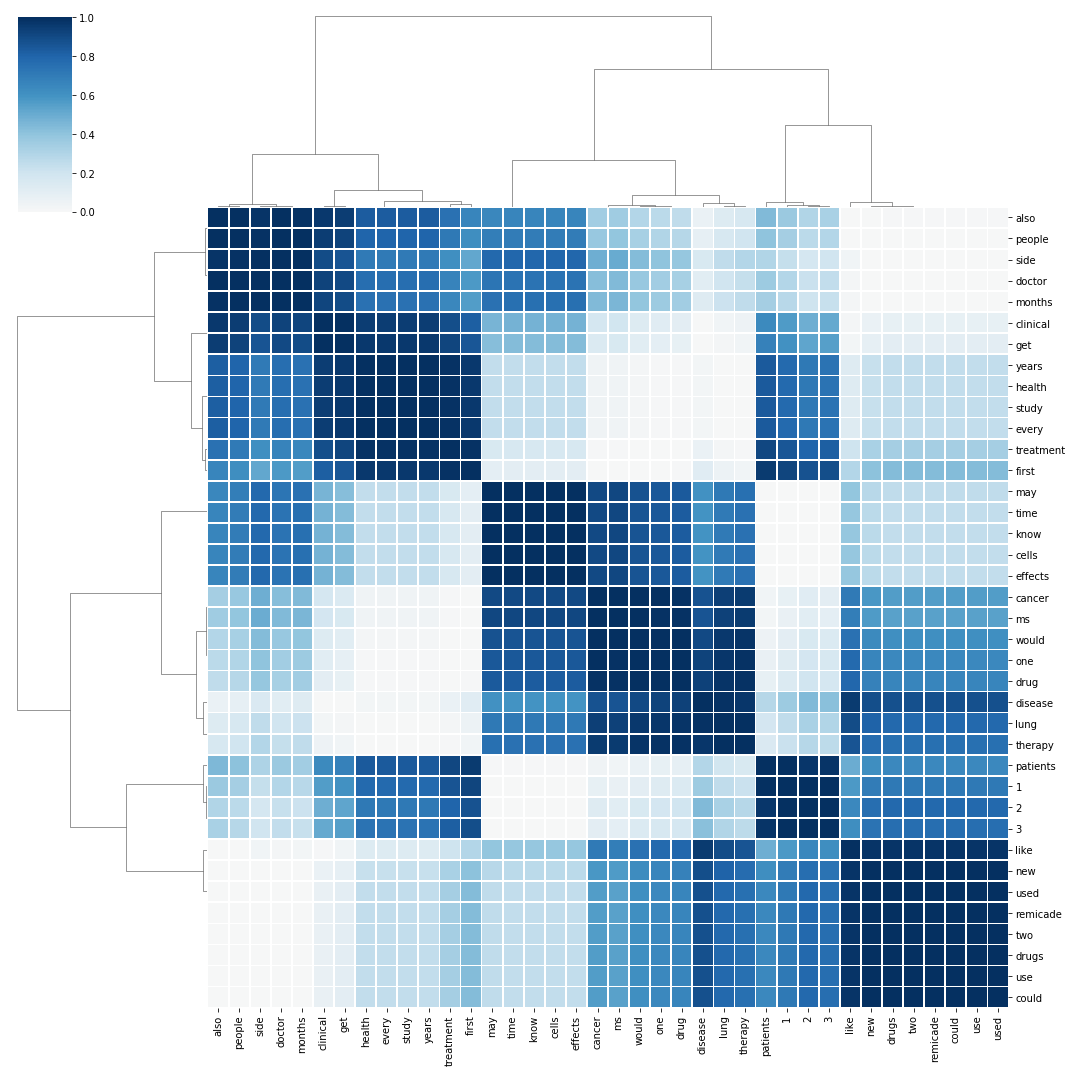

In [93]:
g=sns.clustermap(df_lda.corr(), center=0, standard_scale=1, cmap="RdBu", metric='cosine', linewidths=.75, figsize=(15, 15))
plt.setp(g.ax_heatmap.yaxis.get_majorticklabels(), rotation=0)
plt.show()
#plt.setp(ax_heatmap.get_yticklabels(), rotation=0)  # For y axis

In [0]:
pyLDAvis.enable_notebook()
panel = pyLDAvis.gensim.prepare(lda, corpus_lda, dictionary,mds='mmds')
panel